# Mixed Up Testing

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms

import matplotlib.pyplot as plt

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

import config
from celeba_dataset import CelebaDataset
import losses

## Load Dataset

In [2]:
def load_dataloader(print_info=True, albu_transforms = True):
    if config.evaluate:
        phases = ['test']
    else:
        phases = ['train', 'val']

    attribute_names = ['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 
                       'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 
                       'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
                       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 
                       'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline',
                       'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 
                       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young']
    
    attributes_list = {
        'train': config.TRAIN_ATTRIBUTE_LIST,
        'val': config.VAL_ATTRIBUTE_LIST,
        'test': config.TEST_ATTRIBUTE_LIST
    }

    batch_sizes = {
        'train': config.train_batch,
        'val': config.test_batch,
        'test': config.test_batch
    }
    if not albu_transforms:
        normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                         std=[0.229, 0.224, 0.225])
        data_transforms = {
            'train': transforms.Compose([
                transforms.Resize(128), #new
                transforms.CenterCrop(128), #new
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomRotation(degrees=10), #new
                transforms.ToTensor(),
                normalize,
                transforms.RandomErasing()
            ]),
            'val': transforms.Compose([
                transforms.Resize(128), #new
                transforms.ToTensor(),
                normalize
            ]),
            'test': transforms.Compose([
                transforms.Resize(128), #new
                transforms.ToTensor(),
                normalize
            ])
        }
    else:
        normalize_A = A.Normalize(mean=(0.485, 0.456, 0.406), 
                                  std=(0.229, 0.224, 0.225))
        data_transforms = {
            'train': A.Compose([
                #A.RandomResizedCrop(148, 148), # cuts out too much attributes, use centercrop instead
                A.CenterCrop(height=148, width=148),
                A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, 
                                 rotate_limit=15, p=0.5), # AFFACT https://arxiv.org/pdf/1611.06158.pdf
                A.HorizontalFlip(p=0.5),
                #A.HueSaturationValue(hue_shift_limit=14, sat_shift_limit=14, val_shift_limit=14, p=0.5),
                #A.FancyPCA(alpha=0.1, p=0.5), #http://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf
                A.RandomBrightnessContrast(p=0.5),
                A.GaussNoise(var_limit=10.0, p=0.5), 
                #A.GaussianBlur(p=0.1), # AFFACT https://arxiv.org/pdf/1611.06158.pdf
                #A.CoarseDropout(max_holes=1, max_height=74, max_width=74, 
                #               min_height=49, min_width=49, fill_value=0, p=0.2), #https://arxiv.org/pdf/1708.04896.pdf
                normalize_A,
                ToTensorV2(),
                
            ]),
            'val': A.Compose([
                #Rescale an image so that minimum side is equal to max_size 178 (shortest edge of celeba)
                A.SmallestMaxSize(max_size=178), 
                A.CenterCrop(height=168, width=168),
                normalize_A,
                ToTensorV2(),
            ]),
            'test': A.Compose([
                A.SmallestMaxSize(max_size=178),
                A.CenterCrop(height=168, width=168),
                normalize_A,
                ToTensorV2(),
            ])
        }


    image_datasets = {x: CelebaDataset(config.IMG_DIR, attributes_list[x], 
                                       data_transforms[x]) 
                      for x in phases}
    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                                                  batch_size=batch_sizes[x],
                                                  pin_memory=True, shuffle=(x == 'train'), 
                                                  num_workers=config.dl_workers) 
                   for x in phases}
    if print_info:
        dataset_sizes = {x: len(image_datasets[x]) for x in phases}
        print(f"Dataset sizes: {dataset_sizes}")
        
    if config.evaluate:
        class_names = image_datasets['test'].targets
    else:
        class_names = image_datasets['train'].targets
        
    print(f"Class Labels: {len(class_names[0])}")
    assert len(attribute_names) == len(class_names[0])
    return image_datasets, dataloaders, attribute_names

image_datasets, dataloaders, attr_names = load_dataloader(albu_transforms = True)

Dataset sizes: {'train': 162770, 'val': 19867}
Class Labels: 40


## Test MixedUP

In [3]:
@torch.no_grad()
def mixup_data(x, y, alpha=0.2):
    """Returns mixed inputs, pairs of targets, and lambda
    """
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    mixed_x = lam * x + (1 - lam) * x.flip(dims=(0,))
    y_a, y_b = y, y.flip(dims=(0,))    
    return mixed_x, y_a, y_b, lam

In [4]:
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

lam: 0.002667982214676957
ori_a: tensor([0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1])
labels_a: tensor([[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
         1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
         1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1]])
changed_a: tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True])

ori_b: tensor([0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1])
labels_b: tensor([[0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
         1, 0, 0, 0, 

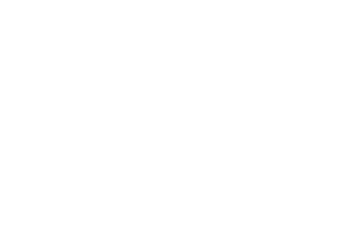

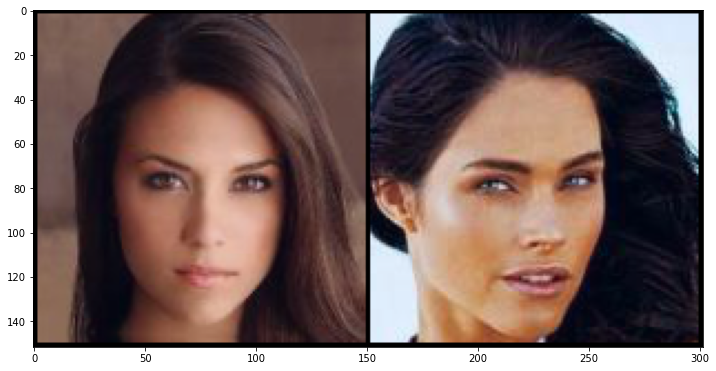

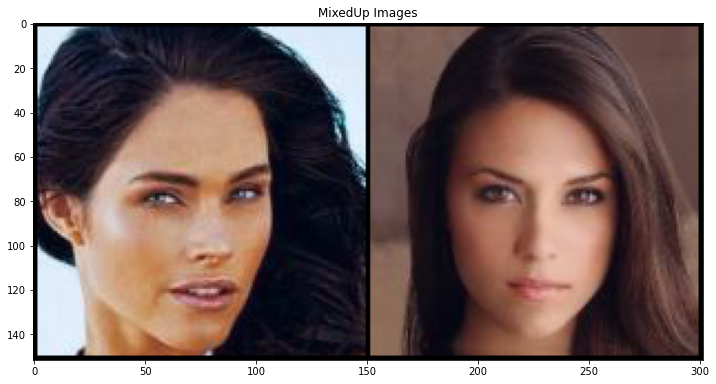

In [5]:
real_batch = next(iter(dataloaders['train']))

data = real_batch[0].to(device, non_blocking=True)[:2]
labels = real_batch[1].to(device, non_blocking=True)[:2]
mdata, labels_a, labels_b, lam = mixup_data(data, labels, alpha=0.2)
print(f"lam: {lam}")
plt.axis("off")
plt.figure(figsize=(12,12))
plt.imshow(np.transpose(torchvision.utils.make_grid(data, padding=2, normalize=True).cpu(),(1,2,0)))
plt.figure(figsize=(12,12))
plt.imshow(np.transpose(torchvision.utils.make_grid(mdata, padding=2, normalize=True).cpu(),(1,2,0)))
plt.title("MixedUp Images")
print(f"ori_a: {labels[0]}")
print(f"labels_a: {labels_a}")
print(f"changed_a: {labels_a[0] == labels[0]}")
print("")
print(f"ori_b: {labels[1]}")
print(f"labels_b: {labels_b}")
print(f"changed_b: {labels_b[0] == labels[1]}")
print("")
print(f"same_lab: {labels_b[0] == labels_a[0]}")
print(f"same_img: {data[0] == mdata[0]}")

In [6]:
@torch.no_grad()
def mixup_data2(x, y, alpha=0.2):
    """Returns mixed inputs, pairs of targets, and lambda
    """
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    mixed_x = lam * x + (1 - lam) * x.flip(dims=(0,))
    y_a, y_b = y, y.flip(dims=(0,))
    print(y_a)
    y_pairs = torch.stack([y_a, y_b], dim=0)
    return mixed_x, y_pairs, lam


real_batch = next(iter(dataloaders['train']))

data = real_batch[0].to(device, non_blocking=True)[:2]
labels = real_batch[1].to(device, non_blocking=True)[:2]
mdata, labels_pairs, lam = mixup_data2(data, labels, alpha=0.2)
print(labels_pairs.shape)
print(labels_pairs)

tensor([[0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0,
         1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0],
        [0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
         1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1]])
torch.Size([2, 2, 40])
tensor([[[0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
          0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0],
         [0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
          0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1]],

        [[0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
          0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1],
         [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
          0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0]]])


In [7]:
lab_a1, lab_b1 = labels_pairs
print(f"lab_a1: {lab_a1.shape}")
print(f"{lab_a1}")

lab_a1: torch.Size([2, 40])
tensor([[0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0,
         1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0],
        [0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
         1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1]])


In [8]:
print(f"labels_a: {labels_a.shape}")

labels_a: torch.Size([2, 40])


In [9]:
lab_a = labels_pairs[0]
print(f"lab_a: {lab_a.shape}")
print(f"{lab_a}")

lab_a: torch.Size([2, 40])
tensor([[0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0,
         1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0],
        [0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
         1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1]])


In [10]:
lab_b = labels_pairs[1]
print(f"lab_b: {lab_b.shape}")
print(f"{lab_b}")

lab_b: torch.Size([2, 40])
tensor([[0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
         1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1],
        [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0,
         1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0]])


In [11]:
def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

In [12]:
criterion = nn.CrossEntropyLoss().to(device)

In [21]:
for i, (data, labels) in enumerate(dataloaders['train']):
    data = data.to(device, non_blocking=True)
    labels = labels.to(device, non_blocking=True)

    data, labels_a, labels_b, lam = mixup_data(data, labels, alpha=0.2)
    mdata, labels_p, lam2 = mixup_data2(data, labels, alpha=0.2)
    lab_a, lab_b = labels_p
    print(labels.shape, labels[:, 0].shape)
    print(labels_a.shape)
    print(labels_p.shape)
    print(labels_p[:, :, 0].shape)
    print(labels_p[0].shape)
    print(lab_a.shape)
    optimizer.zero_grad()
    outputs = model(data)
    loss = mixup_criterion(Loss, outputs, labels_a, labels_b, lam)

    loss.backward()
    optimizer.update()

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 1],
        [0, 0, 1,  ..., 0, 0, 1],
        ...,
        [1, 0, 1,  ..., 1, 0, 1],
        [1, 0, 1,  ..., 0, 0, 1],
        [0, 1, 1,  ..., 0, 0, 1]])
torch.Size([128, 40]) torch.Size([128])
torch.Size([128, 40])
torch.Size([2, 128, 40])
torch.Size([2, 128])
torch.Size([128, 40])
torch.Size([128, 40])


NameError: name 'optimizer' is not defined